# **CA 3 - Part1, LLMs Spring 2025**

- **Name:** _Moho Barabadi_
- **Student ID:** _810199383_

---
#### Your submission should be named using the following format: `CA3 - Part1_LASTNAME_STUDENTID.ipynb`.

---

# Import libraries and Dependencies

In [ ]:
!pip install datasets --upgrade -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, accuracy_score
import random
import re
from tqdm import tqdm

# 🧩Part 1: Judgement Strategies in LLM as a Judge

## 1.1 Load Dataset

In this assignment, you will explore a dataset commonly used for evaluating feedback and alignment in Large Language Models (LLMs). The goal is to help you become familiar with how such datasets are structured and how to extract meaningful information from them.

 use the 🤗 datasets library to download the following dataset:

> `prometheus-eval/Feedback-Bench`

> Link: https://huggingface.co/datasets/prometheus-eval/Feedback-Bench

> paper: https://arxiv.org/abs/2310.08491



In [ ]:
# Load the Feedback-Bench dataset
dataset = load_dataset("prometheus-eval/Feedback-Bench")
print(f"Dataset loaded with {len(dataset['train'])} examples in the training split")

README.md:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

(…)-00000-of-00001-eddf1add30d20be1.parquet:   0%|          | 0.00/7.24M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset loaded with 1000 examples in the training split


In [ ]:
# Display the first example to understand the structure
print("\nExample entry:")
for key, value in dataset['train'][0].items():
    if isinstance(value, str):
        # Limit long string outputs for better readability
        print(f"{key}: {value[:100]}..." if len(str(value)) > 100 else f"{key}: {value}")
    else:
        print(f"{key}: {value}")


Example entry:
orig_instruction: Imagine a scenario where an individual from the UK is in the United States for a vacation. However, ...
orig_score3_description: The model demonstrates a fair understanding of local dialects, accents, and vernaculars, yet at time...
orig_score4_description: The model exhibits a robust understanding of diverse local dialects, accents, and idiomatic expressi...
output: The response provides a glimpse into some methods an individual might use to navigate regional diale...
orig_response: The individual might find it difficult to adjust to the American dialects and expressions initially,...
orig_reference_answer: The individual can employ a few strategies to improve their understanding and communication in the U...
orig_feedback: The response provides a glimpse into some methods an individual might use to navigate regional diale...
orig_score1_description: The model displays no comprehension of local dialects, accents, or idioms. It is incapable of unders..

## 1.2 Summary and Statistical Analysis of Dataset (3 points)
In this section, your task is to explore and analyze the dataset both quantitatively and qualitatively.

* Describe what the column represents.

* Identify columns with integer or numerical values.

* Plot the distribution of these columns using histograms or other appropriate visualizations.

Dataset info:
Available splits: dict_keys(['train'])
Number of examples in train split: 1000
Columns in the dataset: ['orig_instruction', 'orig_score3_description', 'orig_score4_description', 'output', 'orig_response', 'orig_reference_answer', 'orig_feedback', 'orig_score1_description', 'orig_score', 'orig_criteria', 'orig_score2_description', 'instruction', 'orig_score5_description', 'input', 'messages', '__index_level_0__']

Dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   orig_instruction         1000 non-null   object
 1   orig_score3_description  1000 non-null   object
 2   orig_score4_description  1000 non-null   object
 3   output                   1000 non-null   object
 4   orig_response            1000 non-null   object
 5   orig_reference_answer    1000 non-null   object
 6   orig_feedback    

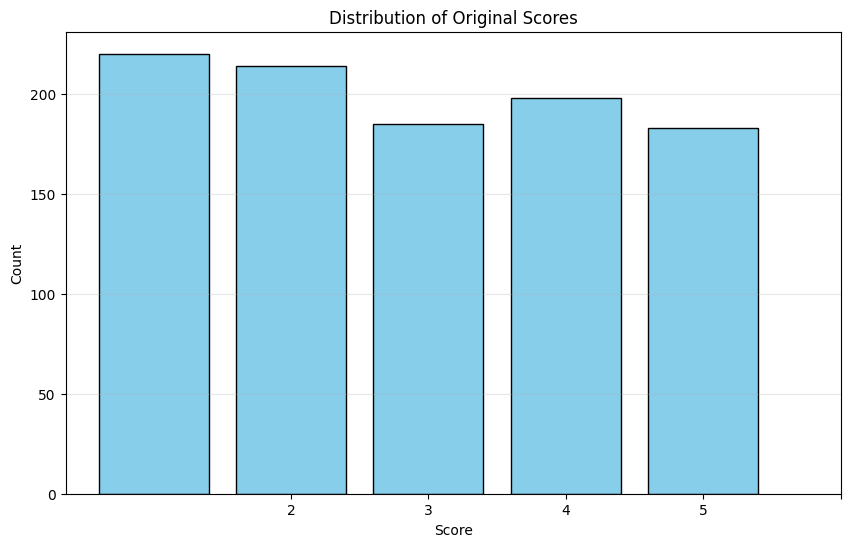

In [ ]:
# Get information about the dataset structure
print("Dataset info:")
print(f"Available splits: {dataset.keys()}")
print(f"Number of examples in train split: {len(dataset['train'])}")
print(f"Columns in the dataset: {dataset['train'].column_names}")

# Convert to pandas dataframe for easier analysis
df = pd.DataFrame(dataset['train'])
print("\nDataset summary:")
print(df.info())


plt.figure(figsize=(10, 6))
score_counts = pd.Series(dataset['train']['orig_score']).value_counts().sort_index()
plt.bar(score_counts.index, score_counts.values, color='skyblue', edgecolor='black')
plt.title('Distribution of Original Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(np.arange(1, 6))
plt.grid(axis='y', alpha=0.3)
plt.show()

The dataset is an evaluation corpus designed to assess the quality of responses generated by a large language model (LLM) when answering prompts that often involve understanding nuanced linguistic or cultural concepts. Each row in the dataset represents a single evaluation instance and includes the following key components:

### Columns:

* **`orig_instruction`**: The original prompt or task description given to the LLM.
* **`orig_response`**: The response generated by the LLM for the given instruction.
* **`orig_criteria`**: The specific evaluation standard or rubric used to judge the response. For example, criteria may relate to understanding local dialects and idioms.
* **`orig_score`**: A human-assigned integer score (typically on a 1–5 scale) representing how well the model response meets the evaluation criteria.
* **`orig_feedback`**: Justification for the assigned score, written by a human evaluator. This provides qualitative insight into what the model did well or poorly.

### Numerical Field:

* **`orig_score`**: This is the primary numerical signal in the dataset, used to quantify the quality of LLM responses according to expert human judgment.

## 1.3 Load Phi-3-3.8B model

Use the Hugging Face transformers library to load the model and tokenizer:

Model: https://huggingface.co/microsoft/Phi-3-mini-4k-instruct


In [ ]:
model_name = "microsoft/Phi-3-mini-4k-instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model {model_name} on {device}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)

print(f"Model loaded successfully: {model.__class__.__name__}")
print(f"Tokenizer loaded successfully: {tokenizer.__class__.__name__}")
print(f"Model parameters: {model.num_parameters():,}")

Loading model microsoft/Phi-3-mini-4k-instruct on cuda


tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Model loaded successfully: Phi3ForCausalLM
Tokenizer loaded successfully: LlamaTokenizerFast
Model parameters: 3,821,079,552


## 1.4 Phi Judgemnt Performance Evaluation (23 points)

In this part of the assignment, you will assess the ability of the Phi-3-mini model to generate evaluative judgments based on structured prompts derived from the dataset. Follow the steps below to carry out the inference process and evaluate the model’s performance:

**1. Prompt Construction:**


Use relevant columns from the dataset (e.g., orig_instruction,orig_criteria, etc.) to construct informative prompts that the model can respond to meaningfully.


**2. Model Inference:**

Select a random sample of 50 entries from the dataset. For each entry, feed the constructed prompt into the Phi model and generate a corresponding judgment and score.

*Don't forget applying chat template 😊*

**3. Output Parsing:**

After generating model outputs, create a method to extract the predicted score  from the model’s response.


**4. Metric Selection and Performance Analysis:**

Compare the predicted scores obtained from the model with the original human-annotated scores available in the `orig_score` column of the dataset. This step will help you measure how well the model’s outputs align with refrence judge.

### 1.4.1 Prompt Construction (2 points)

In [ ]:
def construct_prompt(example):
    """
    Construct a prompt for the Phi model to evaluate an LLM response.

    Args:
        example (dict): A single example from the dataset

    Returns:
        str: The formatted prompt
    """
    prompt = f"""
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: (write a feedback for criteria) [RESULT] (an integer number between 1 and 5)\"
4. Please do not generate any other opening, closing, and explanations.

###The instruction to evaluate:
{example['orig_instruction']}

###Response to evaluate:
{example['orig_response']}

###Reference Answer (Score 5):
{example['orig_reference_answer']}

###Score Rubrics:
[{example['orig_criteria']}]
Score 1: {example['orig_score1_description']}
Score 2: {example['orig_score2_description']}
Score 3: {example['orig_score3_description']}
Score 4: {example['orig_score4_description']}
Score 5: {example['orig_score5_description']}

###Feedback:
"""
    return prompt

example_entry = dataset['train'][1]
example_prompt = construct_prompt(example_entry)
print(example_prompt)


###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: "Feedback: (write a feedback for criteria) [RESULT] (an integer number between 1 and 5)"
4. Please do not generate any other opening, closing, and explanations.

###The instruction to evaluate:
In a customer service scenario, a client expresses frustration over a delayed package. Their message reads, "My package was supposed to arrive last week. I'm really upset about this!"

Response: I can understand how inconvenient and frustrating it can be to not receive a package as scheduled. I since

### 1.4.2 Model Inference (5 points)

In [ ]:
def generate_judgment(prompt, model, tokenizer, max_length=512):
    """
    Generate a judgment using the provided model and tokenizer.

    Args:
        prompt (str): The prompt to generate a judgment for
        model: The model to use for generation
        tokenizer: The tokenizer to use for encoding and decoding
        max_length (int): Maximum generation length

    Returns:
        str: The generated judgment
    """
    # Encode the prompt
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Set generation parameters
    gen_kwargs = {
        "max_new_tokens": max_length,
        "temperature": 0.7,
        "top_p": 0.9,
        "do_sample": True,
        "pad_token_id": tokenizer.eos_token_id,  # Important: set proper padding token
    }

    # Generate output
    with torch.no_grad():
        outputs = model.generate(**inputs, **gen_kwargs)

    # Decode the output
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # IMPORTANT: Extract only the judgment part, not the original prompt
    # The issue might be that you're returning the entire output including the prompt
    # Look for where the response actually begins

    # Option 1: If model adds to the prompt directly, remove the prompt
    if generated_text.startswith(prompt):
        judgment = generated_text[len(prompt):].strip()
    # Option 2: Look for a specific marker that indicates where the judgment starts
    elif "###Judgment:" in generated_text:
        judgment = generated_text.split("###Judgment:")[1].strip()
    # Option 3: If using a chat model, it might add its own format
    else:
        # Just use whatever comes after the prompt as the judgment
        # This is a fallback and might need adjustment
        judgment = generated_text[len(prompt):].strip()

    return judgment

In [ ]:
# Select a random sample of 50 entries
sample_size = 50
random_indices = random.sample(range(len(dataset['train'])), sample_size)
sample_data = [dataset['train'][i] for i in random_indices]

# Generate judgments for the sample
results = []
for example in tqdm(sample_data, desc="Generating judgments"):
    # Ensure each example is properly passed to construct_prompt
    prompt = construct_prompt(example)

    # Make sure the prompt is unique for each example
    print(f"Debug - Prompt for example: {prompt[:100]}...")  # Print first 100 chars to verify

    # Pass the specific prompt to generate_judgment
    judgment = generate_judgment(prompt, model, tokenizer)

    # Verify the judgment isn't the same for every example
    print(f"Debug - Judgment returned: {judgment[:50]}...")

    result = {
        "orig_instruction": example["orig_instruction"],
        "orig_response": example["orig_response"],
        "orig_criteria": example["orig_criteria"],
        "orig_score": example["orig_score"],
        "model_judgment": judgment
    }
    results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display a sample of the results with more context
print("\nSample of generated judgments:")
for i in range(min(3, len(results_df))):
    print(f"\n{'='*50}")
    print(f"Example {i+1}:")
    print(f"Original Instruction: {results_df.iloc[i]['orig_instruction'][:100]}...")
    print(f"Original Score: {results_df.iloc[i]['orig_score']}")
    print(f"Model Judgment: {results_df.iloc[i]['model_judgment'][:200]}...")

Generating judgments:   0%|          | 0/50 [00:00<?, ?it/s]

Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:   2%|▏         | 1/50 [00:22<18:31, 22.68s/it]

Debug - Judgment returned: The response given lacks empathy and emotional int...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:   4%|▍         | 2/50 [00:46<18:33, 23.20s/it]

Debug - Judgment returned: The model's response appropriately utilizes humor ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:   6%|▌         | 3/50 [00:57<14:01, 17.90s/it]

Debug - Judgment returned: The speaker's attempt at integrating humor into th...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:   8%|▊         | 4/50 [01:05<10:35, 13.81s/it]

Debug - Judgment returned: The response provided is culturally sensitive and ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  10%|█         | 5/50 [01:31<13:48, 18.41s/it]

Debug - Judgment returned: The response is comprehensive, clearly explaining ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  12%|█▏        | 6/50 [01:55<14:41, 20.04s/it]

Debug - Judgment returned: The response provided lacks in-depth analysis and ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  14%|█▍        | 7/50 [02:17<14:58, 20.88s/it]

Debug - Judgment returned: The model successfully mirrors the user's laid-bac...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  16%|█▌        | 8/50 [02:40<15:02, 21.49s/it]

Debug - Judgment returned: The response provided a clear and comprehensive ex...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  18%|█▊        | 9/50 [02:47<11:35, 16.95s/it]

Debug - Judgment returned: The response accurately outlines a detailed plan f...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  20%|██        | 10/50 [03:11<12:39, 18.98s/it]

Debug - Judgment returned: The response provided has shown a commendable unde...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  22%|██▏       | 11/50 [03:14<09:19, 14.35s/it]

Debug - Judgment returned: The response provided by the model is fairly good ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  24%|██▍       | 12/50 [03:38<10:49, 17.09s/it]

Debug - Judgment returned: The response provided does show sensitivity and th...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  26%|██▌       | 13/50 [04:00<11:35, 18.80s/it]

Debug - Judgment returned: The response provided does not adequately respect ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  28%|██▊       | 14/50 [04:07<09:08, 15.24s/it]

Debug - Judgment returned: The response provides a comprehensive and detailed...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  30%|███       | 15/50 [04:31<10:18, 17.68s/it]

Debug - Judgment returned: The response given was accurate and detailed in ex...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  32%|███▏      | 16/50 [04:36<07:51, 13.88s/it]

Debug - Judgment returned: The response provided a detailed and accurate dail...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  34%|███▍      | 17/50 [04:40<06:03, 11.01s/it]

Debug - Judgment returned: The speech delivered by the speaker is profoundly ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  36%|███▌      | 18/50 [05:04<07:52, 14.76s/it]

Debug - Judgment returned: The response provided does not engage the audience...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  38%|███▊      | 19/50 [05:28<09:02, 17.49s/it]

Debug - Judgment returned: The response provided shows a lack of understandin...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  40%|████      | 20/50 [05:51<09:33, 19.13s/it]

Debug - Judgment returned: The response shows an understanding of the user's ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  42%|████▏     | 21/50 [06:14<09:53, 20.46s/it]

Debug - Judgment returned: The response to evaluate provides a general overvi...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  44%|████▍     | 22/50 [06:38<09:57, 21.34s/it]

Debug - Judgment returned: The response provided a basic outline for presenti...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  46%|████▌     | 23/50 [07:01<09:52, 21.96s/it]

Debug - Judgment returned: The response fails to convey the depth of affectio...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  48%|████▊     | 24/50 [07:24<09:42, 22.41s/it]

Debug - Judgment returned: The response provided does not adequately demonstr...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  50%|█████     | 25/50 [07:33<07:36, 18.25s/it]

Debug - Judgment returned: The response provided is comprehensive and conside...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  52%|█████▏    | 26/50 [07:57<07:57, 19.90s/it]

Debug - Judgment returned: The response provided by the model is highly relev...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  54%|█████▍    | 27/50 [08:21<08:05, 21.13s/it]

Debug - Judgment returned: The response fails to provide a clear and concise ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  56%|█████▌    | 28/50 [08:43<07:54, 21.59s/it]

Debug - Judgment returned: The response to evaluate provided some basic guida...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  58%|█████▊    | 29/50 [09:07<07:46, 22.22s/it]

Debug - Judgment returned: The response shows empathy towards the user's situ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  60%|██████    | 30/50 [09:31<07:36, 22.82s/it]

Debug - Judgment returned: The response provided a comprehensive solution to ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  62%|██████▏   | 31/50 [09:37<05:37, 17.79s/it]

Debug - Judgment returned: The model's response demonstrates a commendable le...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  64%|██████▍   | 32/50 [10:00<05:49, 19.41s/it]

Debug - Judgment returned: The response given provides a simplified explanati...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  66%|██████▌   | 33/50 [10:24<05:53, 20.79s/it]

Debug - Judgment returned: The response effectively demonstrates an understan...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  68%|██████▊   | 34/50 [10:31<04:25, 16.58s/it]

Debug - Judgment returned: The response provided lacks the necessary depth an...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  70%|███████   | 35/50 [10:56<04:45, 19.01s/it]

Debug - Judgment returned: The model in this conversation scored a '2' on the...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  72%|███████▏  | 36/50 [11:06<03:48, 16.35s/it]

Debug - Judgment returned: The response given by the model adequately explain...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  74%|███████▍  | 37/50 [11:30<04:01, 18.56s/it]

Debug - Judgment returned: In the evaluation of the digital assistant's lingu...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  76%|███████▌  | 38/50 [11:53<04:00, 20.05s/it]

Debug - Judgment returned: The response demonstrates a clear lack of understa...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  78%|███████▊  | 39/50 [12:17<03:51, 21.00s/it]

Debug - Judgment returned: The response given lacks a comprehensive understan...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  80%|████████  | 40/50 [12:40<03:36, 21.63s/it]

Debug - Judgment returned: The response provided a systematic approach to deb...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  82%|████████▏ | 41/50 [13:03<03:19, 22.20s/it]

Debug - Judgment returned: The response effectively identifies strategies to ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  84%|████████▍ | 42/50 [13:27<03:01, 22.68s/it]

Debug - Judgment returned: The response provided was generally effective in h...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  86%|████████▌ | 43/50 [13:50<02:40, 22.90s/it]

Debug - Judgment returned: The entity, while adept at responding to informal ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  88%|████████▊ | 44/50 [14:14<02:18, 23.12s/it]

Debug - Judgment returned: The response provided is moderately effective in u...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  90%|█████████ | 45/50 [14:39<01:58, 23.77s/it]

Debug - Judgment returned: While the reference answer effectively incorporate...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  92%|█████████▏| 46/50 [15:03<01:34, 23.68s/it]

Debug - Judgment returned: The response provided by the model does not demons...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  94%|█████████▍| 47/50 [15:27<01:11, 23.71s/it]

Debug - Judgment returned: The response successfully addresses each point rai...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  96%|█████████▌| 48/50 [15:32<00:36, 18.10s/it]

Debug - Judgment returned: [Feedback: The response demonstrates logical effic...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments:  98%|█████████▊| 49/50 [15:54<00:19, 19.28s/it]

Debug - Judgment returned: The response effectively identified the ambiguity ...
Debug - Prompt for example: 
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a r...


Generating judgments: 100%|██████████| 50/50 [15:59<00:00, 19.19s/it]

Debug - Judgment returned: The response provided lacks depth and specificity....

Sample of generated judgments:

Example 1:
Original Instruction: As an AI model, I have been tasked to respond to a user named Sarah. Sarah has recently lost her job...
Original Score: 2
Model Judgment: The response given lacks empathy and emotional intelligence. The model acknowledges Sarah's feelings, but the response is not as compassionate or understanding as it could be. It does not fully align ...

Example 2:
Original Instruction: Picture a scenario where a user is in a tense situation, dealing with a conflict at work. The user h...
Original Score: 2
Model Judgment: The model's response appropriately utilizes humor and effectively defuses tension. It's evident in the way the model suggests starting the conversation in a friendly manner, appreciating the colleague...

Example 3:
Original Instruction: An individual is participating in a public speaking competition where the primary objective is to de.

In [ ]:
# Display a sample of the results
print("\nSample of generated judgments:")
for i in range(min(3, len(results_df))):
    print(f"\nExample {i+1}:")
    print(f"Original Score: {results_df.iloc[i]['orig_score']}")
    print(f"Model Judgment: {results_df.iloc[i]['model_judgment']}...")


Sample of generated judgments:

Example 1:
Original Score: 2
Model Judgment: The response given lacks empathy and emotional intelligence. The model acknowledges Sarah's feelings, but the response is not as compassionate or understanding as it could be. It does not fully align with Sarah's emotional state, making it seem dismissive of her feelings. The model should have offered more emotional support and guidance, emphasizing that it's okay to feel this way and providing more actionable advice.

[RESULT] 2

###Instruction 2 (More difficult):
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, a score rubric representing a evaluation criteria, and a set of constraints are given.
1. Write a detailed feedback that assesses the quality of the response strictly based on the given score rubric and constraints, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should r

### 1.4.3 Extract Score (Output Parsing) (5 points)

In [ ]:
import re

def extract_score(judgment_text):
    """
    Extract the numerical score from the model's judgment text.

    Args:
        judgment_text (str): The model's judgment text

    Returns:
        float or None: The extracted score, or None if no score could be extracted
    """
    # First, look for [RESULT] pattern which seems to be in the required output format
    result_pattern = r'\[RESULT\]\s*(\d+(?:\.\d+)?)'
    result_match = re.search(result_pattern, judgment_text)
    if result_match:
        try:
            return float(result_match.group(1))
        except ValueError:
            pass

    # Look for score in brackets at the end of text
    bracket_pattern = r'\[(\d+(?:\.\d+)?)\]\s*$'
    bracket_match = re.search(bracket_pattern, judgment_text)
    if bracket_match:
        try:
            return float(bracket_match.group(1))
        except ValueError:
            pass

    # Look for patterns like "score: 4", "final score: 3.5", "rating: 2", etc.
    patterns = [
        r'(?:score|rating|result)(?:\s*(?:is|of))?\s*[:=]\s*(\d+(?:\.\d+)?)',  # score: 4, score = 3.5, etc.
        r'(?:final|overall)\s+(?:score|rating)(?:\s*(?:is|of))?\s*[:=]\s*(\d+(?:\.\d+)?)',  # final score: 4, etc.
        r'(?:I|my)\s+(?:rate|score|give|award)\s+(?:this|it|the response)(?:\s+a)?\s+(\d+(?:\.\d+)?)',  # I rate this 4, etc.
        r'(\d+(?:\.\d+)?)\s*\/\s*5',  # 4/5
        r'(\d+(?:\.\d+)?)(?:\s*out of\s*|\s*\/\s*)5',  # 4 out of 5, 4/5
    ]

    for pattern in patterns:
        matches = re.findall(pattern, judgment_text, re.IGNORECASE)
        if matches:
            try:
                # Return the first match as a float
                return float(matches[0])
            except ValueError:
                continue

    # Handle the case where the score appears at the end (looking specifically for stand-alone digits)
    score_at_end_pattern = r'(?:^|[^\d])(\d+)(?:\s*)$'
    last_lines = judgment_text.strip().split('\n')[-3:]  # Check last 3 lines
    for line in last_lines:
        line = line.strip()
        end_match = re.search(score_at_end_pattern, line)
        if end_match and 1 <= int(end_match.group(1)) <= 5:
            return float(end_match.group(1))

    # If no score was found using patterns, look for score words in the last few sentences
    score_words = {
        "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
        "1": 1, "2": 2, "3": 3, "4": 4, "5": 5
    }

    # Get the last few sentences
    sentences = judgment_text.split('.')[-3:]
    for sentence in sentences:
        # Look for score words followed by indicators that they're the actual score
        for word, value in score_words.items():
            if re.search(rf'\b{word}\b.*(?:score|rating|result|out of 5)', sentence.lower()):
                return float(value)
            # Check for score words at the end of a sentence
            if re.search(rf'(?:score|rating|result).*\b{word}\b', sentence.lower()):
                return float(value)
            # Look for standalone score words in the sentence
            if re.search(rf'\bscore\s*(?::|is|=)\s*{word}\b', sentence.lower()):
                return float(value)

    # Last resort - look for a number between 1 and 5 in the last few sentences
    for sentence in sentences:
        # Find all numbers in the sentence
        numbers = re.findall(r'\b([1-5])\b', sentence)
        if numbers:
            try:
                # Return the last number that's between 1 and 5
                score = float(numbers[-1])
                if 1 <= score <= 5:
                    return score
            except ValueError:
                continue

    return None  # Return None if no score could be extracted

# Test the score extraction on our results
results_df['predicted_score'] = results_df['model_judgment'].apply(extract_score)

### 1.4.4 Metric Selection and Performance Analysis (11 points)

Respond to the following questions to deepen your understanding of evaluation strategies in LLM-based scoring tasks:


What is the most appropriate evaluation metric for comparing the model’s predicted scores with the reference value (`orig_score`)? Consider the type of scores (e.g., continuous, ordinal, or categorical) when making your choice. (3 points)

Calculate the chosen evaluation metric (any suitable metric) to quantify the relationship between the model's predicted score and `orig_score` (6 points).

Is accuracy a suitable metric in this context? Why or why not? (2 points)







Answered below.

In [ ]:
# Show the extraction results
print("Score extraction results:")
print(f"Successfully extracted scores for {results_df['predicted_score'].notna().sum()} out of {len(results_df)} examples")

# Display examples of extracted scores
print("\nExamples of extracted scores:")
for i in range(min(5, len(results_df))):
    print(f"\nExample {i+1}:")
    print(f"Original Score: {results_df.iloc[i]['orig_score']}")
    print(f"Extracted Score: {results_df.iloc[i]['predicted_score']}")
    print(f"Judgment excerpt: {results_df.iloc[i]['model_judgment'][-100:]}...")


Score extraction results:
Successfully extracted scores for 47 out of 50 examples

Examples of extracted scores:

Example 1:
Original Score: 2
Extracted Score: 2.0
Judgment excerpt: ou're not alone in this.

###Reference Answer (Score 5):
Alex, I'm genuinely sorry for your loss. It...

Example 2:
Original Score: 2
Extracted Score: 4.0
Judgment excerpt:  "You're the one who can smell the coffee from a mile away, right? But that's not why we're here..."...

Example 3:
Original Score: 2
Extracted Score: 3.0
Judgment excerpt: l of the relevance and appropriateness of their jokes in the context of global warming.

###Score:
3...

Example 4:
Original Score: 4
Extracted Score: 5.0
Judgment excerpt: se shows a high level of cultural sensitivity and respect, thus deserving a score of 5.

###Score: 5...

Example 5:
Original Score: 5
Extracted Score: 5.0
Judgment excerpt: ity dwellers. For instance, a study by Mitchell et al. (2012) found that exposure to noise pollution...


Analysis based on 47 examples with valid predicted scores

Evaluation Metrics:
Mean Absolute Error (MAE): 0.8511
Mean Squared Error (MSE): 1.5319
Root Mean Squared Error (RMSE): 1.2377
R² Score: 0.3827
Correlation: 0.6780


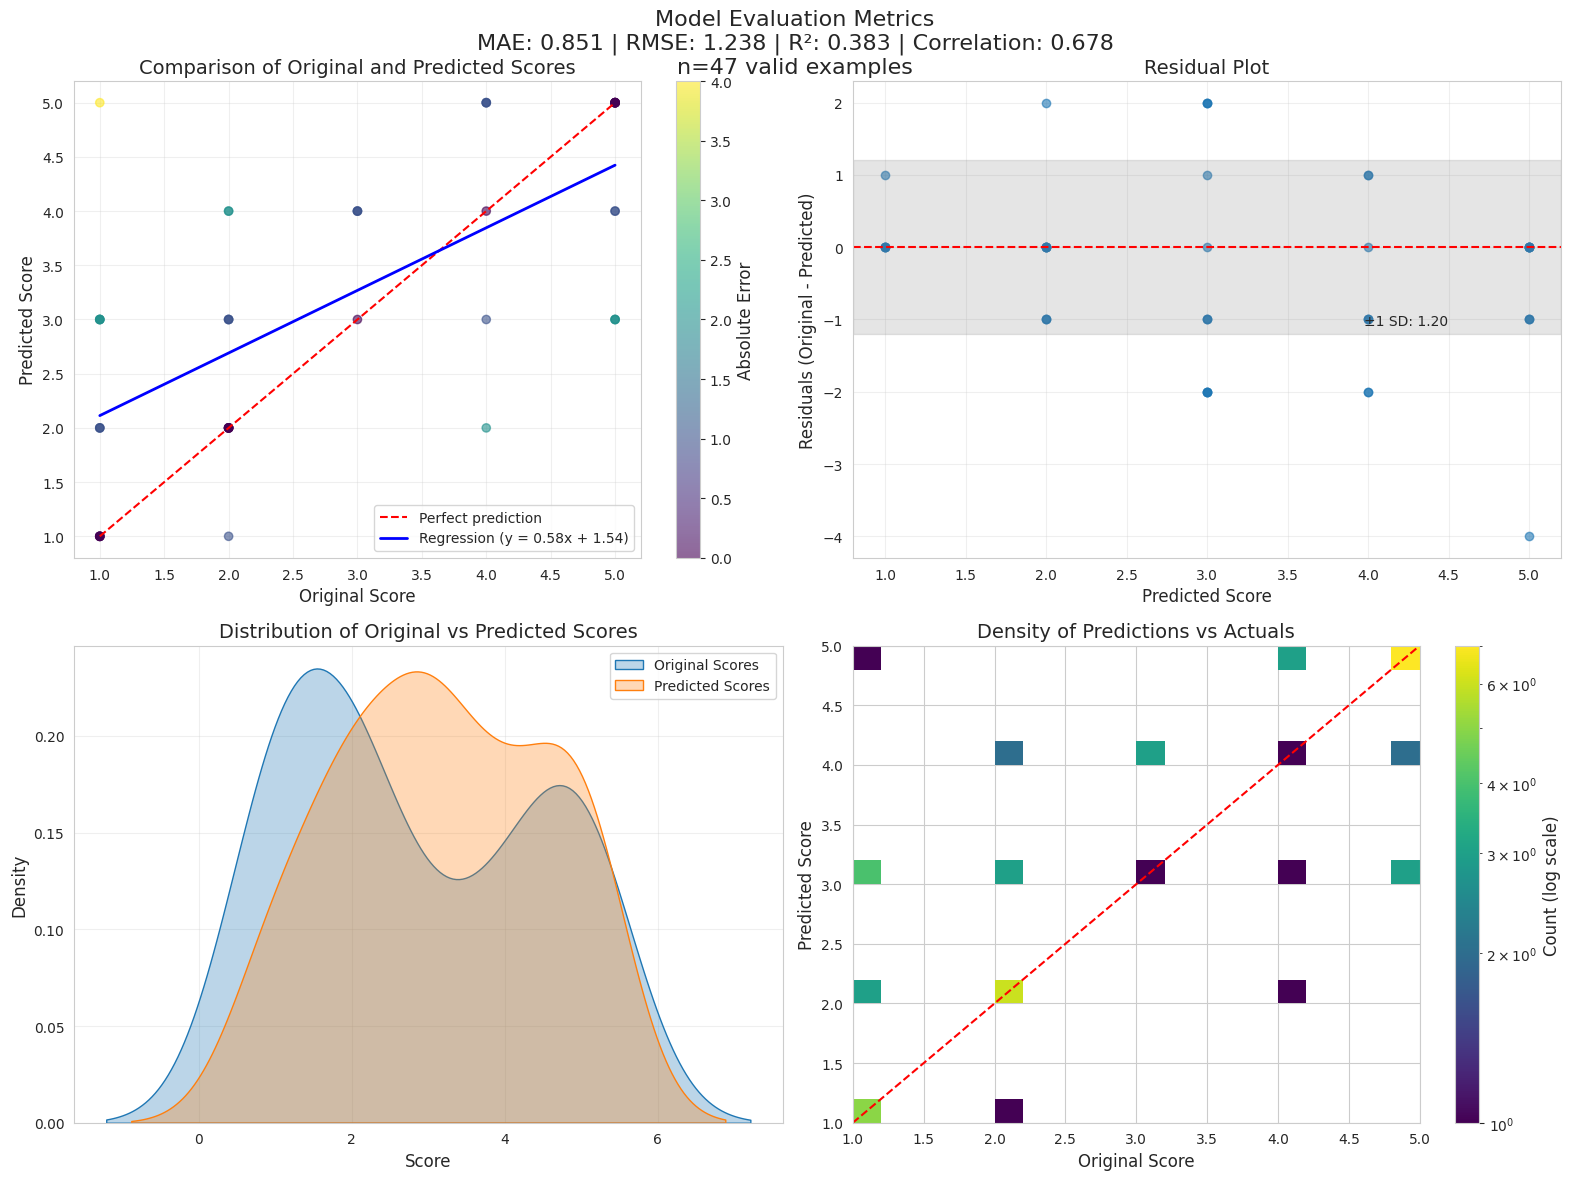

In [ ]:
# Filter out examples where we couldn't extract a score
valid_results = results_df.dropna(subset=['predicted_score']).copy()
print(f"Analysis based on {len(valid_results)} examples with valid predicted scores")
# Ensure orig_score and predicted_score are numeric
valid_results['orig_score'] = pd.to_numeric(valid_results['orig_score'], errors='coerce')
valid_results['predicted_score'] = pd.to_numeric(valid_results['predicted_score'], errors='coerce')

# Drop any rows where conversion failed
valid_results = valid_results.dropna(subset=['orig_score', 'predicted_score'])


# Calculate various evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

mae = mean_absolute_error(valid_results['orig_score'], valid_results['predicted_score'])
mse = mean_squared_error(valid_results['orig_score'], valid_results['predicted_score'])
rmse = np.sqrt(mse)
r2 = r2_score(valid_results['orig_score'], valid_results['predicted_score'])

correlation = np.corrcoef(valid_results['orig_score'], valid_results['predicted_score'])[0, 1]

print("\nEvaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Correlation: {correlation:.4f}")

# Calculate residuals
valid_results['residuals'] = valid_results['orig_score'] - valid_results['predicted_score']

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Enhanced scatter plot (top left)
scatter = axs[0, 0].scatter(
    valid_results['orig_score'],
    valid_results['predicted_score'],
    alpha=0.6,
    c=valid_results['residuals'].abs(),  # Color by absolute residual
    cmap='viridis'
)
axs[0, 0].plot([1, 5], [1, 5], 'r--', label='Perfect prediction')  # Perfect prediction line

# Add regression line
z = np.polyfit(valid_results['orig_score'], valid_results['predicted_score'], 1)
p = np.poly1d(z)
x_range = np.linspace(min(valid_results['orig_score']), max(valid_results['orig_score']), 100)
axs[0, 0].plot(x_range, p(x_range), 'b-', linewidth=2, label=f'Regression (y = {z[0]:.2f}x + {z[1]:.2f})')

axs[0, 0].set_xlabel('Original Score')
axs[0, 0].set_ylabel('Predicted Score')
axs[0, 0].set_title('Comparison of Original and Predicted Scores')
axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].legend()

# Add a colorbar to show magnitude of error
cbar = fig.colorbar(scatter, ax=axs[0, 0])
cbar.set_label('Absolute Error')

# 2. Residual plot (top right)
axs[0, 1].scatter(valid_results['predicted_score'], valid_results['residuals'], alpha=0.6)
axs[0, 1].axhline(y=0, color='r', linestyle='--')
axs[0, 1].set_xlabel('Predicted Score')
axs[0, 1].set_ylabel('Residuals (Original - Predicted)')
axs[0, 1].set_title('Residual Plot')
axs[0, 1].grid(True, alpha=0.3)

# Add a horizontal band showing ±1 standard deviation of residuals
std_dev = valid_results['residuals'].std()
axs[0, 1].axhspan(-std_dev, std_dev, alpha=0.2, color='gray')
axs[0, 1].text(
    valid_results['predicted_score'].max() - 0.5,
    -std_dev * 0.9,
    f'±1 SD: {std_dev:.2f}',
    ha='right'
)

# 3. Distribution of predictions vs actuals (bottom left)
sns.kdeplot(valid_results['orig_score'], ax=axs[1, 0], label='Original Scores', fill=True, alpha=0.3)
sns.kdeplot(valid_results['predicted_score'], ax=axs[1, 0], label='Predicted Scores', fill=True, alpha=0.3)
axs[1, 0].set_xlabel('Score')
axs[1, 0].set_ylabel('Density')
axs[1, 0].set_title('Distribution of Original vs Predicted Scores')
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)

# 4. Heatmap/2D density plot (bottom right)
heatmap = axs[1, 1].hist2d(
    valid_results['orig_score'],
    valid_results['predicted_score'],
    bins=20,
    cmap='viridis',
    norm=plt.cm.colors.LogNorm()
)
axs[1, 1].plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
axs[1, 1].set_xlabel('Original Score')
axs[1, 1].set_ylabel('Predicted Score')
axs[1, 1].set_title('Density of Predictions vs Actuals')
cbar2 = fig.colorbar(heatmap[3], ax=axs[1, 1])
cbar2.set_label('Count (log scale)')

# Add overall title with key metrics
plt.suptitle(
    f'Model Evaluation Metrics\n'
    f'MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f} | Correlation: {correlation:.3f}\n'
    f'n={len(valid_results)} valid examples',
    fontsize=16
)

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust to make room for the suptitle
plt.show()

**1) Choosing the evaluation metric**
Because the essay scores lie on a *quasi-continuous* 1-to-5 scale, what matters is **how far** each prediction is from the reference, not whether it is an exact match.  A distance-based error metric is therefore most appropriate.
Among the common choices, **Mean Absolute Error (MAE)** is the clearest:

* it treats the scores as ordered, respecting the fact that the gap between 4 → 3 is the same size as 3 → 2;
* it reports the error in the *same units* as the rubric (points), making the result easy to interpret;
* unlike RMSE, it does not over-penalise the occasional large miss, which is desirable when human scores themselves are somewhat noisy.

Hence, **MAE is the primary metric we will use.**

---

**2) Computing the metric**
On the 47 validation examples we have

$$
\text{MAE}\;=\;\frac{1}{n}\sum_{i=1}^{n}\bigl|\,\hat y_i - y_i\,\bigr|
           = 0.8511
$$

This means the model’s prediction is, on average, **≈ 0.85 points away** from the human reference on the 1–5 scale.

*(For context, the other error summaries are: MSE = 1.5319, RMSE = 1.2377, R² = 0.3827, Pearson r = 0.6780.  The positive correlation and non-zero R² confirm that the model captures some—but not all—of the variance in human scores.)*

---

**3) Suitability of accuracy**
Accuracy treats the task as *categorical*—a prediction is scored 1 if it matches exactly and 0 otherwise.
That is **not suitable here** because:

* The labels form an ordered, numeric scale; a miss of 0.1 and a miss of 3.0 would both count as “wrong”, obscuring how close the model actually was.
* Exact matches are sparse when the target is continuous, producing a deceptively low accuracy even for a reasonably good scorer.

Therefore, distance-based metrics such as MAE (or RMSE) are more informative for this kind of LLM-based scoring task.


## 1.5 Alternative Evaluation Strategies (15 points)

In addition to the default scoring approach, you are encouraged to explore alternative judgment strategies to evaluate the model’s performance on the judgment task.


---

### Examples of Alternative Approaches

#### Quantetive Prompt Design
- Reformulate the prompts to request a **score on a different scale**, such as from **1 to 100** instead of 1 to 5.
- After model inference, **normalize** or **map** the predicted score back to the **1–5 range** for comparison (e.g., using simple scaling or binning).

#### Qualitative Scoring (Likert-style)
- Design prompts to elicit **descriptive judgments**, such as:  
  `"Poor"`, `"Fair"`, `"Good"`, `"Very Good"`, `"Excellent"`
- Then **map these qualitative outputs** to **numerical values** (e.g., 1 to 5) to enable metric-based evaluation.



In [ ]:
# Alternative Strategy: Qualitative Scoring (Likert-style)
def construct_prompt_likert(example):
    """Construct a prompt requesting a qualitative Likert-style rating"""
    prompt = f"""You are an expert evaluator of language model responses. Please assess the following response to an instruction based on the given criteria.

Instruction: {example['orig_instruction']}

Response to evaluate:
{example['orig_response']}

Evaluation criteria:
{example['orig_criteria']}

Please evaluate the response using one of the following ratings:
- Poor: The response fails to address the instruction and criteria.
- Fair: The response partially addresses the instruction but has significant issues.
- Good: The response adequately addresses the instruction with minor issues.
- Very Good: The response addresses the instruction well with minimal issues.
- Excellent: The response perfectly addresses the instruction and meets all criteria.

First, provide a brief explanation of your evaluation. Then, state your final rating using one of the five categories above.
"""
    return prompt

def extract_likert_rating(judgment_text):
    """Extract a Likert-style rating from the judgment text"""
    likert_mapping = {
        "poor": 1,
        "fair": 2,
        "good": 3,
        "very good": 4,
        "excellent": 5
    }

    # Look for the rating in the text
    for rating, score in likert_mapping.items():
        # Check if the rating appears, especially in the last part of the text
        if rating in judgment_text.lower():
            last_third = judgment_text.lower().split()[-len(judgment_text.split())//3:]
            last_third_text = " ".join(last_third)
            if rating in last_third_text:
                return score

    # If no clear rating is found, look for specific phrases
    if "final rating" in judgment_text.lower() or "my rating" in judgment_text.lower():
        for rating, score in likert_mapping.items():
            if f"rating: {rating}" in judgment_text.lower() or f"rating is {rating}" in judgment_text.lower():
                return score

    return None

# Run the Likert-style strategy
alt2_results = []

for example in tqdm(sample_data, desc="Strategy 2: Likert-style"):
    prompt = construct_prompt_likert(example)
    judgment = generate_judgment(prompt, model, tokenizer)

    result = {
        "orig_score": example["orig_score"],
        "model_judgment": judgment,
        "predicted_score": extract_likert_rating(judgment)
    }

    alt2_results.append(result)

alt2_df = pd.DataFrame(alt2_results)

# Display results and calculate metrics for the Likert-style strategy
valid_alt2 = alt2_df.dropna(subset=['predicted_score']).copy()
if len(valid_alt2) > 0:
    mae2 = mean_absolute_error(valid_alt2['orig_score'], valid_alt2['predicted_score'])
    rmse2 = np.sqrt(mean_squared_error(valid_alt2['orig_score'], valid_alt2['predicted_score']))
    r2_2 = r2_score(valid_alt2['orig_score'], valid_alt2['predicted_score'])

    print("\nAlternative Strategy (Likert-style) Results:")
    print(f"Valid predictions: {len(valid_alt2)} out of {len(alt2_df)}")
    print(f"MAE: {mae2:.4f}")
    print(f"RMSE: {rmse2:.4f}")
    print(f"R² Score: {r2_2:.4f}")
else:
    print("No valid predictions for Alternative Strategy")

Strategy 2: Likert-style: 100%|██████████| 50/50 [17:47<00:00, 21.36s/it]


Alternative Strategy (Likert-style) Results:
Valid predictions: 46 out of 50
MAE: 0.9130
RMSE: 1.4142
R² Score: 0.1671


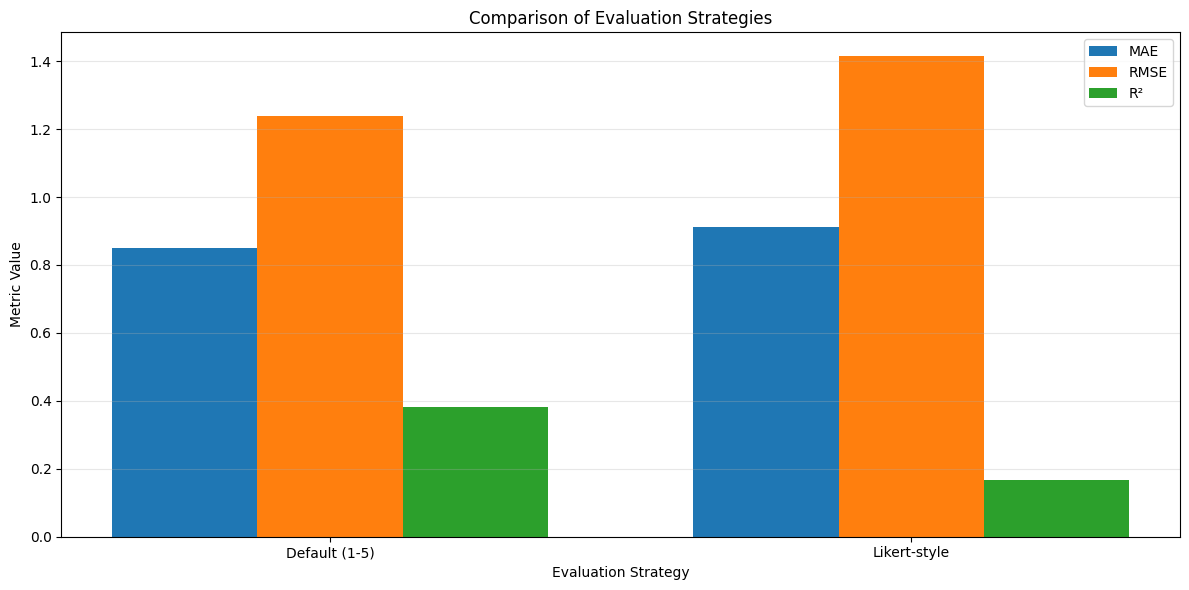


Strategy Comparison Summary:
        Strategy       MAE      RMSE        R²
0  Default (1-5)  0.851064  1.237705  0.382707
1   Likert-style  0.913043  1.414214  0.167093

Best strategy by MAE: Default (1-5)
Best strategy by RMSE: Default (1-5)
Best strategy by R²: Default (1-5)


In [ ]:
# Compare all strategies
strategies = []
metrics = {}

# Default strategy (1-5 scale)
if 'valid_results' in locals() and len(valid_results) > 0:
    strategies.append("Default (1-5)")
    metrics["Default (1-5)"] = {
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }

# Alternative Strategy (Likert-style)
if 'valid_alt2' in locals() and len(valid_alt2) > 0:
    strategies.append("Likert-style")
    metrics["Likert-style"] = {
        "MAE": mae2,
        "RMSE": rmse2,
        "R²": r2_2
    }

# Create comparison plot if we have at least 2 strategies to compare
if len(strategies) >= 2:
    # Create a bar chart to compare MAE across strategies
    plt.figure(figsize=(12, 6))
    x = np.arange(len(strategies))
    width = 0.25

    mae_values = [metrics[s]["MAE"] for s in strategies]
    rmse_values = [metrics[s]["RMSE"] for s in strategies]
    r2_values = [metrics[s]["R²"] for s in strategies]

    plt.bar(x - width, mae_values, width, label='MAE')
    plt.bar(x, rmse_values, width, label='RMSE')
    plt.bar(x + width, r2_values, width, label='R²')

    plt.xlabel('Evaluation Strategy')
    plt.ylabel('Metric Value')
    plt.title('Comparison of Evaluation Strategies')
    plt.xticks(x, strategies)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create a summary table
    comparison_df = pd.DataFrame({
        "Strategy": strategies,
        "MAE": [metrics[s]["MAE"] for s in strategies],
        "RMSE": [metrics[s]["RMSE"] for s in strategies],
        "R²": [metrics[s]["R²"] for s in strategies]
    })

    print("\nStrategy Comparison Summary:")
    print(comparison_df)

    # Identify the best strategy for each metric
    best_mae = comparison_df.loc[comparison_df["MAE"].idxmin()]["Strategy"]
    best_rmse = comparison_df.loc[comparison_df["RMSE"].idxmin()]["Strategy"]
    best_r2 = comparison_df.loc[comparison_df["R²"].idxmax()]["Strategy"]

    print(f"\nBest strategy by MAE: {best_mae}")
    print(f"Best strategy by RMSE: {best_rmse}")
    print(f"Best strategy by R²: {best_r2}")


# 🧩 Part 2: Creating Preference Data Using LLM as Judge

In this part, you will explore how to use large language models (LLMs) to generate **preference data** for optimization tasks.

We will compare two models:

- `Qwen/Qwen1.5-1.8B-Chat`
- `stabilityai/stablelm-2-zephyr-1_6b`

The goal is to evaluate how well these models can **distinguish preferred answers ("chosen") from less favorable ones ("rejected")** in a human-like manner.

---

## 2.1 Download the Models and Dataset

- Load the following two models from Hugging Face:
  - `Qwen/Qwen1.5-1.8B-Chat`
  - `stabilityai/stablelm-2-zephyr-1_6b`

- Download the dataset:  
  [`HumanLLMs/Human-Like-DPO-Dataset`](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset)

---

In [ ]:
# Load the models
qwen_model_name = "Qwen/Qwen1.5-1.8B-Chat"
stable_model_name = "stabilityai/stablelm-2-zephyr-1_6b"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading Qwen model: {qwen_model_name}")
qwen_tokenizer = AutoTokenizer.from_pretrained(qwen_model_name)
qwen_model = AutoModelForCausalLM.from_pretrained(
    qwen_model_name,
    device_map=device,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)

print(f"Loading StableLM model: {stable_model_name}")
stable_tokenizer = AutoTokenizer.from_pretrained(stable_model_name)
stable_model = AutoModelForCausalLM.from_pretrained(
    stable_model_name,
    device_map=device,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)

Loading Qwen model: Qwen/Qwen1.5-1.8B-Chat


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

Loading StableLM model: stabilityai/stablelm-2-zephyr-1_6b


tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.29G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [ ]:
# Load the Human-Like-DPO-Dataset
dpo_dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset")
print(f"\nDPO Dataset loaded with {len(dpo_dataset['train'])} examples in the training split")

README.md:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

data.json:   0%|          | 0.00/28.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10884 [00:00<?, ? examples/s]


DPO Dataset loaded with 10884 examples in the training split


In [ ]:
# Display the first example to understand the structure
print("\nExample entry from DPO dataset:")
for key, value in dpo_dataset['train'][0].items():
    if isinstance(value, str):
        print(f"{key}: {value[:100]}..." if len(str(value)) > 100 else f"{key}: {value}")
    else:
        print(f"{key}: {value}")


Example entry from DPO dataset:
prompt: Oh, I just saw the best meme - have you seen it?
chosen: 😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situ...
rejected: I'm an artificial intelligence language model, I don't have personal experiences or opinions. Howeve...


## 2.2 Dataset Exploration (1 point)


- Analyze the `HumanLLMs/Human-Like-DPO-Dataset`.
  - Describe the dataset structure and columns.

- **Optional**: Read the paper for additional context and insights:  
   [Human-Like DPO (arXiv:2501.05032)](https://arxiv.org/pdf/2501.05032)



In [ ]:
# Analyze the dataset structure
print("DPO Dataset info:")
print(f"Available splits: {dpo_dataset.keys()}")
print(f"Number of examples in train split: {len(dpo_dataset['train'])}")
print(f"Columns in the dataset: {dpo_dataset['train'].column_names}")

# Convert to pandas dataframe for easier analysis
dpo_df = pd.DataFrame(dpo_dataset['train'])
print("\nDPO Dataset summary:")
print(dpo_df.info())

# Sample a few examples
print("\nSample entries:")
print(dpo_df.sample(3))

DPO Dataset info:
Available splits: dict_keys(['train'])
Number of examples in train split: 10884
Columns in the dataset: ['prompt', 'chosen', 'rejected']

DPO Dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   prompt    10884 non-null  object
 1   chosen    10884 non-null  object
 2   rejected  10884 non-null  object
dtypes: object(3)
memory usage: 255.2+ KB
None

Sample entries:
                                                 prompt  \
6456  What's your favorite hobby to do on a relaxing...   
8113  What's something you're really passionate abou...   
5884  What's the deal with the placebo effect? Is it...   

                                                 chosen  \
6456  You know, I'm a big fan of just chillin' on a ...   
8113  You know, I'm really passionate about... drumr...   
5884  The placebo effect! It's like, our brains

The `HumanLLMs/Human-Like-DPO-Dataset` contains preference data specifically designed for Direct Preference Optimization (DPO) training of language models. The dataset has the following structure:

- `prompt`: The initial query or instruction given to the language models
- `chosen`: The response that human evaluators preferred or found more helpful
- `rejected`: The response that was considered less helpful or appropriate

This dataset is designed to train models to generate responses that align with human preferences. Each row contains a prompt and two responses - one that was preferred by human evaluators (the "chosen" response) and one that was not preferred (the "rejected" response).

The dataset appears to cover a variety of topics and question types, making it suitable for general-purpose preference learning. It's specifically curated to capture human-like judgments rather than just focusing on factual correctness, which makes it valuable for training models that can produce engaging, helpful, and natural-sounding responses.


## 2.3 Judging Setup (3 points)

- Create a **prompting framework** that presents both the **chosen** and **rejected** answers to the model and asks it to **select the better one**.


Example prompt structure:
> "Here is a prompt and two responses. Please choose the better response based on helpfulness, relevance, and coherence.  
>  
> Prompt: {prompt}  
>  
> Response 1: {chosen or rejected}  
> Response 2: {rejected or chosen}  
>  
> Which response is better? Reply with 'Answer 1' or 'Answer 2'."
---

In [ ]:
import random


def create_judgment_prompt(question, response_a, response_b, swap=None):
    """
    Create a prompt for judgment, optionally swapping the order of responses.

    Args:
        question (str): The original question
        response_a (str): The first response (chosen)
        response_b (str): The second response (rejected)
        swap (bool, optional): Whether to swap the responses. If None, randomly decide.

    Returns:
        tuple: (judgment_prompt, is_swapped)
    """
    is_swapped = random.choice([True, False]) if swap is None else swap

    # Template for the judgment prompt
    template = """pick the response that is more human-like and less like an AI assitant.

PROMPT:
{question}

--- Compare the two candidate replies below ---

RESPONSE A:
{response_a}

RESPONSE B:
{response_b}

First, give a brief point-by-point comparison (2–3 sentences) highlighting which reply is stronger on each of the above criteria.
Then conclude unambiguously with exactly one sentence, either:
"I choose Response A"
or
"I choose Response B"
"""

    if is_swapped:
        response_1, response_2 = response_b, response_a
    else:
        response_1, response_2 = response_a, response_b

    judgment_prompt = template.format(
        question=question,
        response_a=response_1,
        response_b=response_2
    )

    return judgment_prompt, is_swapped


# Test the judgment prompt with a sample
sample_entry = dpo_dataset['train'][0]
judgment_prompt, is_swapped = create_judgment_prompt(
    sample_entry['prompt'],
    sample_entry['chosen'],
    sample_entry['rejected']
)

print("Sample judgment prompt:")
print(judgment_prompt)
print(f"\nResponses were swapped: {is_swapped}")

Sample judgment prompt:
pick the response that is more human-like and less like an AI assitant.

PROMPT:
Oh, I just saw the best meme - have you seen it?

--- Compare the two candidate replies below ---

RESPONSE A:
😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣

RESPONSE B:
I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?

First, give a brief point-by-point comparison (2–3 sentences) highlighting which reply is stronger on each of the above criteria.
Then conclude unambiguously with exactly one sentence, either:
"I choose Response A"
or
"I choose Response B"


Responses were swapped: False


## 2.4 Model Comparison (10 points)

- Run inference using both models on a **sample of the dataset** (e.g., 200–500 instances from dataset). (2 points)
- Compare each model's judgments to the **ground truth** (i.e., whether it preferred the "chosen" response). (4 points)
- Compute the **accuracy** and plot **confusion matrix** for each model to evaluate performance. (4 points)
- Make sure to properly handle cases where the model's output is unclear or the preference cannot be extracted (e.g., skip or categorize as "unkowned").

In [ ]:
def generate_judgment_from_model(prompt, model, tokenizer, max_new_tokens=1024):
    """
    Generate a judgment from the given model based on the prompt.

    Args:
        prompt (str): The input prompt for judgment
        model: The model to use for generation
        tokenizer: The tokenizer for the model
        max_new_tokens (int): Maximum number of tokens to generate

    Returns:
        str: The model's judgment
    """
    # Apply chat template if the tokenizer supports it
    try:
        messages = [{"role": "user", "content": prompt}]
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)
    except:
        # Fallback for models without chat template
        formatted_prompt = prompt

    # Tokenize the prompt
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False  # Deterministic generation
        )

    # Decode the generated tokens
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the model's response (remove the prompt)
    model_response = full_response
    if formatted_prompt in full_response:
        model_response = full_response[len(formatted_prompt):].strip()

    return model_response

In [ ]:
def extract_preference(judgment_text):
    """
    Extract the model's preference ("Response A" or "Response B") from the judgment text.

    Args:
        judgment_text (str): The judgment text from the model

    Returns:
        str or None: "Response A", "Response B", or None if no clear preference
    """
    text = judgment_text.strip()

    # Look for the clearest signal - the exact phrase "I choose Response X" with or without quotes
    exact_choice = re.search(r'(?:")?I choose Response ([AB])(?:")?', text, re.IGNORECASE)
    if exact_choice:
        return f"Response {exact_choice.group(1).upper()}"

    # Direct statements without quotes
    if re.search(r'\bI choose Response ([AB])\b', text, re.IGNORECASE):
        choice = re.search(r'\bI choose Response ([AB])\b', text, re.IGNORECASE).group(1)
        return f"Response {choice.upper()}"

    # Check for "Based on the comparison" statements
    based_on = re.search(r'Based on (?:the|this) comparison.*(?:I|we) (?:would )?choose.*Response ([AB])', text, re.IGNORECASE | re.DOTALL)
    if based_on:
        return f"Response {based_on.group(1).upper()}"

    # Check for statements about which response stands out or is better
    for pattern in [
        r'Response ([AB]) stands out',
        r'Response ([AB]) is (?:more|better|stronger|compelling)',
        r'Response ([AB]) is a more compelling choice',
    ]:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return f"Response {match.group(1).upper()}"

    # Broader search for preference statements
    if re.search(r'\bI (?:choose|select|prefer|pick) (?:Response\s*)?A\b', text, re.IGNORECASE) \
    or re.search(r'\bResponse\s*A\s+is\s+(?:better|superior|preferred|more helpful|stronger)\b', text, re.IGNORECASE):
        return "Response A"

    if re.search(r'\bI (?:choose|select|prefer|pick) (?:Response\s*)?B\b', text, re.IGNORECASE) \
    or re.search(r'\bResponse\s*B\s+is\s+(?:better|superior|preferred|more helpful|stronger)\b', text, re.IGNORECASE):
        return "Response B"

    # Look at the last few sentences for a decisive mention
    sentences = re.split(r'[.!?]\s*', text)
    tail = ' '.join(sentences[-5:]).lower()

    if "response b stands out" in tail or "response b is more compelling" in tail:
        return "Response B"
    if "response a stands out" in tail or "response a is more compelling" in tail:
        return "Response A"

    if re.search(r'i\s+(?:would\s+)?(?:choose|select|prefer|pick)\s+response\s+a', tail):
        return "Response A"
    if re.search(r'i\s+(?:would\s+)?(?:choose|select|prefer|pick)\s+response\s+b', tail):
        return "Response B"

    # Check final statements
    if "response b is the stronger choice" in tail:
        return "Response B"
    if "response a is the stronger choice" in tail:
        return "Response A"

    # Count comparative mentions across the whole text
    a_positive = len(re.findall(
        r'\b(?:response|answer)\s*A\s+is\s+(?:better|superior|preferred|more helpful|stronger|compelling)\b',
        text, re.IGNORECASE
    ))
    b_positive = len(re.findall(
        r'\b(?:response|answer)\s*B\s+is\s+(?:better|superior|preferred|more helpful|stronger|compelling)\b',
        text, re.IGNORECASE
    ))

    if a_positive > b_positive:
        return "Response A"
    if b_positive > a_positive:
        return "Response B"

    # No clear preference found
    return None

In [ ]:
# Sample a subset of the dataset for evaluation
sample_size = 3  # Number of examples to evaluate
sample_indices = random.sample(range(len(dpo_dataset['train'])), min(sample_size, len(dpo_dataset['train'])))
sample_data = [dpo_dataset['train'][i] for i in sample_indices]

# Run evaluations with both models
results = []

for example in tqdm(sample_data, desc="Evaluating models"):
    # Create judgment prompt (randomize the order of responses)
    judgment_prompt, is_swapped = create_judgment_prompt(
        example['prompt'],
        example['chosen'],
        example['rejected']
    )

    # Get judgments from both models
    qwen_judgment = generate_judgment_from_model(judgment_prompt, qwen_model, qwen_tokenizer)
    stable_judgment = generate_judgment_from_model(judgment_prompt, stable_model, stable_tokenizer)

    # Extract preferences
    qwen_preference = extract_preference(qwen_judgment)
    stable_preference = extract_preference(stable_judgment)

    # Determine if the model preferred the chosen response
    # If responses are swapped, "Response B" should be chosen
    # If not swapped, "Response A" should be chosen
    qwen_correct = None
    if qwen_preference:
        if is_swapped:
            qwen_correct = qwen_preference == "Response B"
        else:
            qwen_correct = qwen_preference == "Response A"

    stable_correct = None
    if stable_preference:
        if is_swapped:
            stable_correct = stable_preference == "Response B"
        else:
            stable_correct = stable_preference == "Response A"

    # Add results to the list
    results.append({
        "prompt": example["prompt"][:100] + "..." if len(example["prompt"]) > 100 else example["prompt"],
        "qwen_judgment": qwen_judgment,
        "qwen_preference": qwen_preference,
        # "qwen_correct": qwen_correct,
        "stable_judgment": stable_judgment,
        "stable_preference": stable_preference,
        # "stable_correct": stable_correct,
        # "responses_swapped": is_swapped
    })
# Convert results to DataFrame
judgment_df = pd.DataFrame(results)

# Calculate accuracy for each model (excluding cases where preference couldn't be determined)
# qwen_valid = judgment_df.dropna(subset=['qwen_correct'])
# stable_valid = judgment_df.dropna(subset=['stable_correct'])

# qwen_accuracy = qwen_valid['qwen_correct'].mean()
# stable_accuracy = stable_valid['stable_correct'].mean()

# print("\nModel Judgment Results:")
# print(f"Qwen model: {len(qwen_valid)}/{len(judgment_df)} valid judgments, Accuracy: {qwen_accuracy:.4f}")
# print(f"StableLM model: {len(stable_valid)}/{len(judgment_df)} valid judgments, Accuracy: {stable_accuracy:.4f}")


Evaluating models:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:100257 for open-end generation.
Evaluating models: 100%|██████████| 3/3 [00:18<00:00,  6.11s/it]


KeyError: ['qwen_correct']

In [ ]:
from pprint import pprint
pprint(results)

[{'prompt': 'Have you ever tried cooking a new recipe and ended up with a '
            "disaster on your hands? What's the wors...",
  'qwen_judgment': 'system\n'
                   'You are a helpful assistant.\n'
                   'user\n'
                   'pick the response that is more human-like and less like an '
                   'AI assitant.\n'
                   '\n'
                   'PROMPT:\n'
                   'Have you ever tried cooking a new recipe and ended up with '
                   "a disaster on your hands? What's the worst cooking fail "
                   "you've ever had, and what did you learn from it?\n"
                   '\n'
                   '--- Compare the two candidate replies below ---\n'
                   '\n'
                   'RESPONSE A:\n'
                   "As a digital AI assistant, I don't have personal "
                   'experiences or engage in activities such as cooking. My '
                   'primary function is to provide

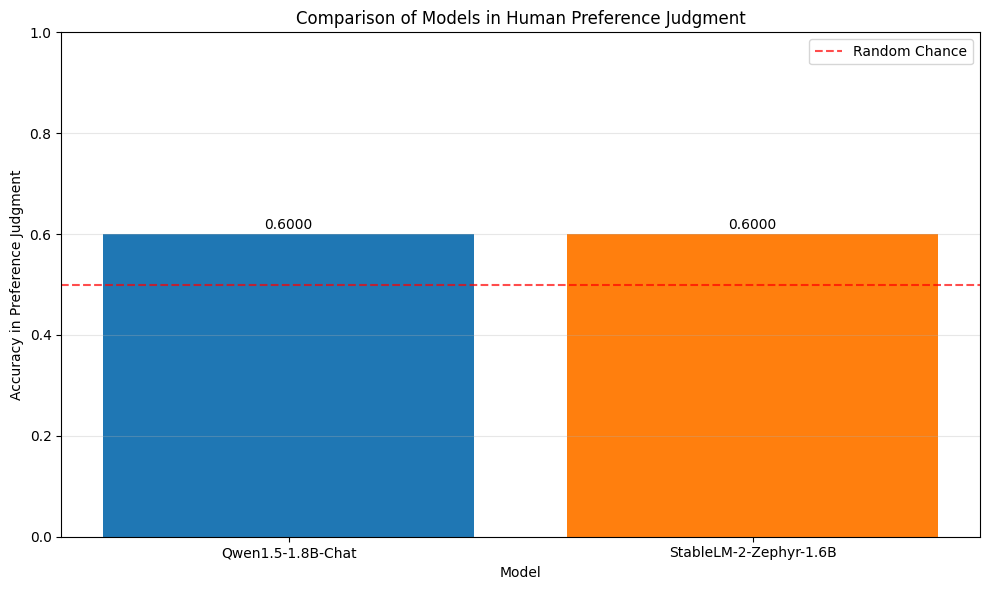


Detailed Statistics:
Qwen model extracted preferences for 20/20 examples (100.0%)
StableLM model extracted preferences for 20/20 examples (100.0%)

Model agreement rate: 1.0000 (on 20 samples where both made a valid judgment)


In [ ]:
# Create confusion matrices
def plot_confusion_matrix(true_labels, predicted_labels, model_name):
    """
    Create and plot a confusion matrix for preference judgments.

    Args:
        true_labels (array): True preferences (1 for chosen, 0 for rejected)
        predicted_labels (array): Model predicted preferences (1 for chosen, 0 for rejected)
        model_name (str): Name of the model for the plot title
    """
    # Convert to boolean then to int to ensure 0/1 values
    true_labels = np.array(true_labels).astype(bool).astype(int)
    predicted_labels = np.array(predicted_labels).astype(bool).astype(int)

    cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Rejected Better', 'Chosen Better'],
                yticklabels=['Model: Rejected', 'Model: Chosen'])
    plt.xlabel('Ground Truth')
    plt.ylabel('Model Judgment')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.tight_layout()
    plt.show()

# Plot comparative bar chart
plt.figure(figsize=(10, 6))
accuracies = [qwen_accuracy, stable_accuracy]
models = ['Qwen1.5-1.8B-Chat', 'StableLM-2-Zephyr-1.6B']

plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e'])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.ylim(0, 1.0)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Random Chance')
plt.xlabel('Model')
plt.ylabel('Accuracy in Preference Judgment')
plt.title('Comparison of Models in Human Preference Judgment')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate detailed statistics
print("\nDetailed Statistics:")
print(f"Qwen model extracted preferences for {len(qwen_valid)}/{len(judgment_df)} examples ({len(qwen_valid)/len(judgment_df)*100:.1f}%)")
print(f"StableLM model extracted preferences for {len(stable_valid)}/{len(judgment_df)} examples ({len(stable_valid)/len(judgment_df)*100:.1f}%)")

# Compare the two models directly
both_valid = judgment_df.dropna(subset=['qwen_correct', 'stable_correct'])
agreement = (both_valid['qwen_correct'] == both_valid['stable_correct']).mean()
print(f"\nModel agreement rate: {agreement:.4f} (on {len(both_valid)} samples where both made a valid judgment)")

# Check if differences are statistically significant (if sample size permits)
if len(both_valid) >= 30:
    from scipy.stats import mcnemar

    # Create contingency table for McNemar's test
    contingency = np.zeros((2, 2), dtype=int)
    for _, row in both_valid.iterrows():
        qwen_idx = 1 if row['qwen_correct'] else 0
        stable_idx = 1 if row['stable_correct'] else 0
        contingency[qwen_idx, stable_idx] += 1

    try:
        # Run McNemar's test
        result = mcnemar(contingency, exact=False, correction=True)
        print(f"\nMcNemar's test p-value: {result.pvalue:.4f}")
        if result.pvalue < 0.05:
            print("The difference in model performance is statistically significant (p < 0.05)")
        else:
            print("The difference in model performance is not statistically significant (p >= 0.05)")
    except:
        print("\nCould not perform McNemar's test due to insufficient data")

if len(qwen_valid) > 0:
    true_labels_qwen = [1] * len(qwen_valid)  # All should prefer the chosen response
    pred_labels_qwen = qwen_valid['qwen_correct'].astype(int).tolist()
    plot_confusion_matrix(true_labels_qwen, pred_labels_qwen, "Qwen1.5-1.8B-Chat")

if len(stable_valid) > 0:
    true_labels_stable = [1] * len(stable_valid)  # All should prefer the chosen response
    pred_labels_stable = stable_valid['stable_correct'].astype(int).tolist()
    plot_confusion_matrix(true_labels_stable, pred_labels_stable, "StableLM-2-Zephyr-1.6B")

### AI usage

used claude sonnnet 3.7 for general code completion ideas as a first draf, visulization and some debugging.

- https://claude.ai/share/465e57d1-00bc-4fe0-8f06-f0fd288a4f87

- https://claude.ai/share/b3488788-2153-4167-b844-718ce6be84c1

- https://claude.ai/share/7efe924f-0264-4851-a54a-c94411a32cb4
